# Exercise 6: Radiative Transfer model of FS CMa

The **oimodeler** package contains a specific class, **oimComponentFitsImage**, to import precomputed images or hyperspectral image-cubes such as outputs from radiative-transfer models in a fits-image format. The loaded image can be shifted, rotated and scaled if necessary and will behave as a component with
five parameters: positions x and y, flux (f), position angle (pa) and scale.

In this example we will load one image-cube created with the radiative transfer code [RADMC3D](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/) as part of the [2021 VLTI School Radiative Transfer practice session](http://www.jmmc.fr/schools/vltischool2021/Radiative%20transfer%20e2e2c101.html)

The aim of the session was to produce a model that would reasonably fit MATISSE observations of the B[e] star FS CMa published in [Hofmann et al. 2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...658A..81H/abstract)

You can download and install: 
- the image-cube named **radmc3d_model.fits**
- the data : 3 files named **2018-12-XXTXXXXXX_HD45677_A0B2D0C1_IR-LM_LOW_Chop_cal_oifits_0.fits**

### Importing libraries, setting the paths, and loading the data

In [2]:
import oimodeler as oim
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

from pathlib import Path
dir0 = Path("C:\\Travail\\Cours et TP\\VLTI2024\\OIDATA\\data\\oifits\\FSCMa_MATISSE\\") 
filenames = list(dir0.glob("*.fits"))
data = oim.oimData(filenames)

dirmodel=Path("C:\\Travail\\Cours et TP\\VLTI2024\\OIMODELER\\modelsRT\\")

image_filename = dirmodel / "radmc3d_model.fits"

### Buliding a model with the image-cube from RADMC3D 

In [4]:
cim = oim.oimComponentFitsImage(image_filename,useinternalPA=False)
model = oim.oimModel(cim)

cim.params['f'].free=False

### The model has two free parameters:
- **pa**: the position angle 
- **scale**: a scaling factor 


In [6]:
model.getFreeParameters()

{'c1_Fits_Comp_pa': oimParam at 0x1b6e002acc0 : pa=0 ± 0 deg range=[-180,180] free=True ,
 'c1_Fits_Comp_scale': oimParam at 0x1b6dffe1f40 : scale=1 ± 0  range=[-inf,inf] free=True }

### Removing zero-padding for faster computation of the FFT

Zero-padding enhances the quality of Fast-Fourier-Transform but significantly increases the computation time.

For an object with a sharp outer edge that fills the field of view (image size) a factor of 4 should be applied.

In our case the outer edge is not very sharp and the object is much smaller than the field of view of our image so we decided to keep the original image size.

In [8]:
oim.oimOptions.ft.padding = 1

### Building a $\chi^2_r$ grid to explore the parameters space

In [10]:
grid=oim.oimFitterRegularGrid(data,model,dataTypes=["VIS2DATA","T3PHI"])
grid.prepare(steps=[10,0.1],min=[-180,0.5],max=[180,3],params=[cim.params["pa"],cim.params["scale"]])
grid.run()

100%|████████████████████████████████████████████████████████████████████████████████| 962/962 [00:19<00:00, 49.27it/s]


{}

### Printing the results and plotting the $\chi^2_r$ map

pa = 170.00000 deg
scale = 1.20000 
chi2r = 490.49730


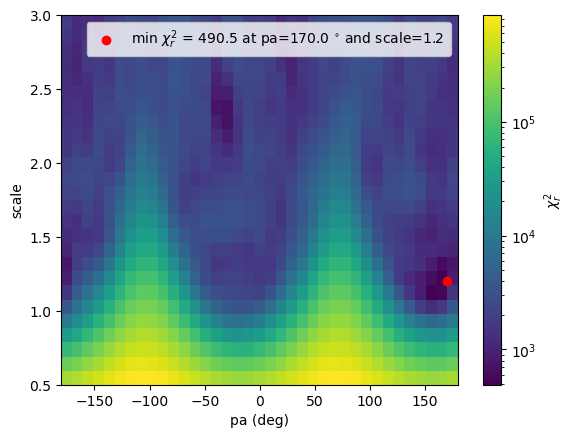

In [12]:
grid.printResults()
fig,ax=grid.plotMap(norm=colors.LogNorm())

### Using simple minimization fitter to converge to the minimum below the grid step size


In [14]:
miniz = oim.oimFitterMinimize(data, model,dataTypes=["VIS2DATA","T3PHI"])
miniz.prepare()
miniz.run()
miniz.printResults()

c1_Fits_Comp_pa = 166.29875 ± 0.00958 deg
c1_Fits_Comp_scale = 1.12607 ± 0.00001 
chi2r = 445.53723


### Printing and plotting results

(0.0, 49148080.0)

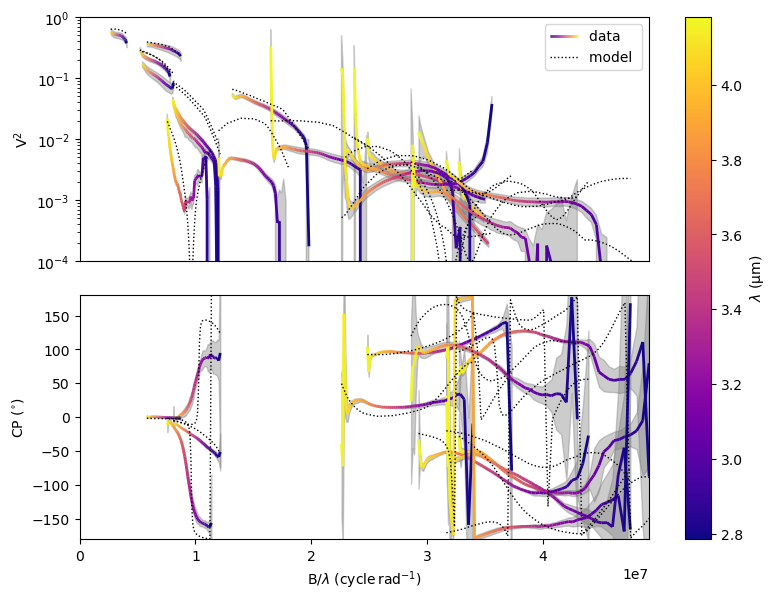

In [20]:
figSim,axSim = miniz.simulator.plot(["VIS2DATA","T3PHI"])
axSim[0].set_yscale("log")
axSim[0].set_ylim(1e-4,1)
axSim[0].set_xlim(left=0)
axSim[1].set_xlim(left=0)

### Plotting the best model images

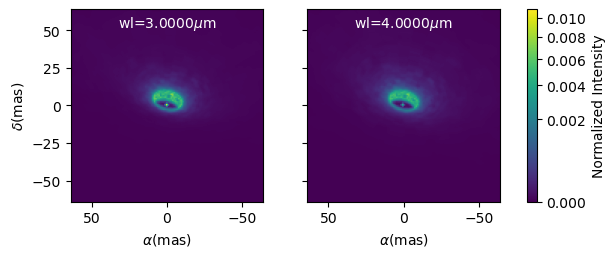

In [22]:
figim, axim, im = model.showModel(128,1,wl=[3e-6,4e-6],legend=True)

#### **Question: Compare your results to those of the [Hofmann et al. 2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...658A..81H/abstract)**